In [1]:
library("DESeq2")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

In [2]:
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/DE/"

In [ ]:
# For more info, refer to https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html

# Input

In [3]:
# DESeq2 analysis with only two replicates: https://support.bioconductor.org/p/106403/
# Michael Love: As long as there is one "degree of freedom", DESeq2 can estimate dispersion. The downside is that the statistical power (sensitivity) drops off very sharply in this range. 

In [ ]:
# See input data generation in "2-1.Fig4ce.SuppFig8.SuppFig10acef.DE_CTCF_degron.ipynb"

In [3]:
# Sample information

sample_f <- file.path(PROJECT_DIR_o, "HCT116_metadata.txt", fsep="/")
coldata <- read.csv(sample_f, row.names=1, sep="\t")
head(coldata, 2)

,Condition
,<chr>
U1,U
U2,U


In [4]:
# Count matrix

count_f <- file.path(PROJECT_DIR_o, "HCT116_counts.txt", fsep="/")
cts <- as.matrix(read.csv(count_f, row.names=1, sep="\t"))
head(cts, 2)

,U1,U2,T1,T2
chr1_998781_999282_minTSS_divergent_distal,7,7,5,8
chr1_998781_999282_maxTSS_divergent_distal,91,107,81,67


In [5]:
# Check if the order is the same

all(rownames(coldata) == colnames(cts))

[1] TRUE

In [6]:
# Construct a DESeqDataSet

dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design = ~ Condition)
dds$Condition <- relevel(dds$Condition, ref = "U")

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


# DE analysis

In [7]:
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [8]:
# https://support.bioconductor.org/p/110307/
# Michael Love: If you want to stick with an FDR bounded set and have the posterior estimates of LFC, I would recommend: keep the p-values and padj from the results() call, and simply update the LFCs so they are posterior estimates.

# https://support.bioconductor.org/p/9135520/
# Michael Love: if you want to find sets of genes that reject the point null (LFC=0), and separately, have evidence of large effect (abs. posterior LFC > 1.5), then that is fine. In the end the important thing is if you know how to interpret the set of genes you are looking at.

In [9]:
# Pre-filtering step can be omitted entirely and just rely on the independent filtering procedures.
# The results function automatically performs independent filtering based on the mean of normalized counts for each element, optimizing the number of elements which will have an adjusted p value below a given FDR cutoff, alpha. The adjusted p values which do not pass the filter threshold are set to NA.
# By default the argument alpha is set to 0.1. If the adjusted p value cutoff will be a value other than 0.1, alpha should be set to that value

res <- results(dds, alpha=0.05)

In [10]:
# Some values in the results table can be set to NA for one of the following reasons:
# 1. If within a row, all samples have zero counts, the baseMean column will be zero, and the log2 fold change estimates, p value and adjusted p value will all be set to NA. In our case, n = 36918 - 36809 = 109.
# 2. If a row contains a sample with an extreme count outlier then the p value and adjusted p value will be set to NA. These outlier counts are detected by Cook’s distance. In our case, n = 0.
# 3. If a row is filtered by automatic independent filtering, for having a low mean normalized count, then only the adjusted p value will be set to NA. In our case, n = 2141.

summary(res)


out of 36809 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 710, 1.9%
LFC < 0 (down)     : 653, 1.8%
outliers [1]       : 0, 0%
low counts [2]     : 2141, 5.8%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



# Diagnostic plots

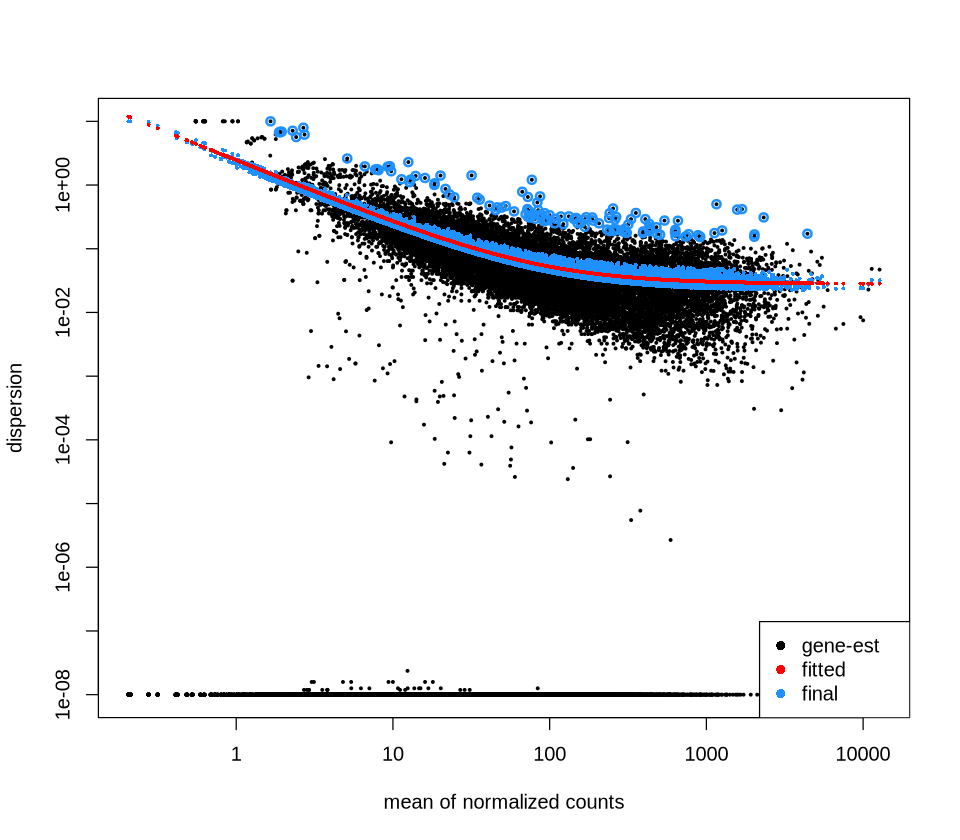

In [11]:
# The final estimates shrunk from the element-wise estimates towards the fitted estimates. Some element-wise estimates are flagged as outliers and not shrunk towards the fitted value. The amount of shrinkage can vary, depending on the sample size, the number of coefficients, the row mean and the variability of the element-wise estimates.

options(repr.plot.width = 8, repr.plot.height = 7)
plotDispEsts(dds)

In [12]:
resultsNames(dds)

[1] "Intercept"        "Condition_T_vs_U"

In [13]:
# lfcShrink: returns a DESeqResults object with the log2FoldChange and lfcSE columns replaced with shrunken LFC and SE.
# type="apeglm" and type="ashr" have shown to have less bias than type="normal"

resLFC <- lfcShrink(dds, type="ashr", res=res)

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



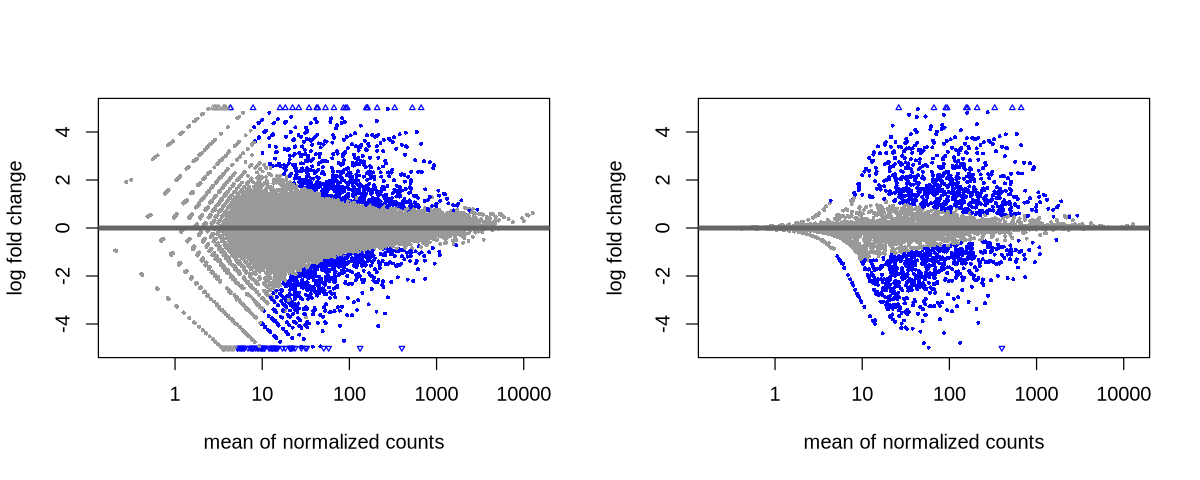

In [14]:
# It is more useful to visualize the MA-plot for the shrunken log2 fold changes, which remove the noise associated with log2 fold changes from low count genes without requiring arbitrary filtering thresholds.
# Points which fall out of the window are plotted as open triangles pointing either up or down.
# alpha: the significance level for thresholding adjusted p-values

options(repr.plot.width = 10, repr.plot.height = 4)
par(mfrow=c(1,2))
plotMA(res, alpha=0.05, ylim=c(-5, 5))
plotMA(resLFC, alpha=0.05, ylim=c(-5, 5))

In [15]:
outputfile <- file.path(PROJECT_DIR_o, "HCT116_DEseq2_R.txt", fsep="/")
write.table(as.data.frame(resLFC), file=outputfile, sep="\t")